# Trend Indicator Pipeline

## Configuration

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ta.trend import EMAIndicator, SMAIndicator, ADXIndicator

from ta.momentum import RSIIndicator, StochasticOscillator

from ta.trend import MACD

from ta.volatility import BollingerBands, AverageTrueRange

from arcticdb.version_store.helper import ArcticMemoryConfig
from arcticdb import Arctic

In [76]:
# Configurations
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

## Moving Average
Simple Moving Average(SMA), Exponential Moving Average(EMA), Average Directional Index(ADX)

In [77]:
class TrendIndicatorPipeline:
    def __init__(self, lib_name='trend_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_sma(self, df, days=7):
        window = days * 1440
        sma = SMAIndicator(close=df['Close'], window=window)
        df[f'sma_{days}d'] = sma.sma_indicator()
        return df

    def compute_ema(self, df, days=7):
        span = days * 1440
        ema = EMAIndicator(close=df['Close'], window=span)
        df[f'ema_{days}d'] = ema.ema_indicator()
        return df

    def compute_adx(self, df, days=14):
        window = days * 1440
        adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=window)
        df[f'adx_{days}d'] = adx.adx()
        return df
    
    def plot_indicators(self, df, sma_days=7, ema_days=20, adx_window=14):
        # Plot SMA and EMA
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
        plt.plot(df.index, df[f'sma_{sma_days}d'], label=f'SMA {sma_days}d')
        plt.plot(df.index, df[f'ema_{ema_days}d'], label=f'EMA {ema_days}d')
        plt.title('Trend Indicators: Close Price, SMA, EMA')
        plt.xlabel('Timestamp')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot ADX
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'adx_{adx_window}d'], label=f'ADX {adx_window}d', color='purple')
        plt.axhline(25, color='gray', linestyle='--', label='Trend Threshold')
        plt.title(f'Average Directional Index (ADX {adx_window})')
        plt.xlabel('Timestamp')
        plt.ylabel('ADX')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def run(self, df: pd.DataFrame, symbol: str, sma_windows=[7], ema_spans=[7], adx_windows=[7]):
        df = df.copy()

        # Compute indicators
        for w in sma_windows:
            df = self.compute_sma(df, days=w)
        for s in ema_spans:
            df = self.compute_ema(df, days=s)
        for d in adx_windows:
            df = self.compute_adx(df, days=d)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written trend indicators for {symbol} to ArcticDB")
        
        # Now plot
        self.plot_indicators(
            df,
            sma_days=sma_windows[0],
            ema_days=ema_spans[0],
            adx_window=adx_windows[0]
        )
        
        return df


Positive Directional Movement: +DM = max(High_t - High_t-1, 0) if it's greater than Low_t-1 - Low_t

Negative Directional Movement: -DM = max(Low_t-1 - Low_t, 0) if it's greater than High_t - High_t-1

True Range (TR): TR_t = max(High_t - Low_t, |High_t - Close_t-1|, |Low_t - Close_t-1|)

Smoothed +DI, -DI: +DI = 100 * (Smoothed +DM) / (Smoothed TR), -DI = 100 * (Smoothed -DM) / (Smoothed TR) using EMA to smooth

DX = 100 * |+DI - -DI| / (+DI + -DI)

ADX: Smoothed DX

In [78]:
class TrendIndicatorPipeline_math:
    def __init__(self, lib_name='trend_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_sma(self, df, days=7):
        window = days * 1440
        df[f'sma_{days}d'] = df['Close'].rolling(window=window).mean()
        return df

    def compute_ema(self, df, days=7):
        span = days * 1440
        df[f'ema_{days}d'] = df['Close'].ewm(span=span, adjust=False).mean()
        return df

    def compute_adx(self, df, days=14):
        window = days * 1440
        # 1. Calculate directional movements
        df['up_move'] = df['High'] - df['High'].shift(1)
        df['down_move'] = df['Low'].shift(1) - df['Low']
        
        df['+DM'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
        df['-DM'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)

        # 2. True Range
        df['tr1'] = df['High'] - df['Low']
        df['tr2'] = abs(df['High'] - df['Close'].shift(1))
        df['tr3'] = abs(df['Low'] - df['Close'].shift(1))
        df['TR'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

        # 3. Smoothed TR, +DM, -DM using Wilder's EMA (alpha=1/window)
        alpha = 1 / window
        df['ATR'] = df['TR'].ewm(alpha=alpha, adjust=False).mean()
        df['+DM_smooth'] = pd.Series(df['+DM']).ewm(alpha=alpha, adjust=False).mean()
        df['-DM_smooth'] = pd.Series(df['-DM']).ewm(alpha=alpha, adjust=False).mean()

        # 4. +DI and -DI
        df['+DI'] = 100 * (df['+DM_smooth'] / df['ATR'])
        df['-DI'] = 100 * (df['-DM_smooth'] / df['ATR'])

        # 5. DX and ADX
        df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
        df[f'adx_{days}d'] = df['DX'].ewm(alpha=alpha, adjust=False).mean()

        # Clean up intermediate columns
        df.drop(columns=['up_move', 'down_move', '+DM', '-DM', 'tr1', 'tr2', 'tr3',
                        'TR', 'ATR', '+DM_smooth', '-DM_smooth', '+DI', '-DI', 'DX'], inplace=True)

        return df
    
    def plot_indicators(self, df, sma_days=7, ema_days=20, adx_window=14):
        # Plot SMA and EMA
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['Close'], label='Close Price', alpha=0.5)
        plt.plot(df.index, df[f'sma_{sma_days}d'], label=f'SMA {sma_days}d')
        plt.plot(df.index, df[f'ema_{ema_days}d'], label=f'EMA {ema_days}d')
        plt.title('Trend Indicators: Close Price, SMA, EMA')
        plt.xlabel('Timestamp')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot ADX
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'adx_{adx_window}d'], label=f'ADX {adx_window}d', color='purple')
        plt.axhline(25, color='gray', linestyle='--', label='Trend Threshold')
        plt.title(f'Average Directional Index (ADX {adx_window})')
        plt.xlabel('Timestamp')
        plt.ylabel('ADX')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


    def run(self, df: pd.DataFrame, symbol: str, sma_windows=[7], ema_spans=[7], adx_windows=[7]):
        df = df.copy()

        # Compute indicators
        for w in sma_windows:
            df = self.compute_sma(df, days=w)
        for s in ema_spans:
            df = self.compute_ema(df, days=s)
        for d in adx_windows:
            df = self.compute_adx(df, days=d)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written trend indicators for {symbol} to ArcticDB")
        
        # Now plot
        self.plot_indicators(
            df,
            sma_days=sma_windows[0],
            ema_days=ema_spans[0],
            adx_window=adx_windows[0]
        )
        
        return df


## Momentum Indicator
Relative Strength Indicator(RSI), Stochastic Oscillator, Moving Average Convergence Divergence (MACD)

In [ ]:
class MomentumIndicatorPipeline:
    def __init__(self, lib_name='momentum_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_rsi(self, df, days=14):
        window = days * 1440
        rsi = RSIIndicator(close=df['Close'], window=window)
        df[f'rsi_{days}d'] = rsi.rsi()
        return df

    def compute_stochastic(self, df, days=14, smooth_days=3):
        window = days * 1440
        smooth_window = smooth_days * 1440
        stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=window, smooth_window=smooth_window)
        df[f'stoch_k_{days}d'] = stoch.stoch()
        df[f'stoch_d_{days}d'] = stoch.stoch_signal()
        return df

    def compute_macd(self, df, fast_days=12, slow_days=26, signal_days=9):
        fast = fast_days * 1440
        slow = slow_days * 1440
        signal = signal_days * 1440
        macd = MACD(close=df['Close'], window_fast=fast, window_slow=slow, window_sign=signal)
        df['macd'] = macd.macd()
        df['macd_signal'] = macd.macd_signal()
        df['macd_diff'] = macd.macd_diff()  # Histogram
        return df
    
    def plot_indicators(self, df, rsi_days=14, stoch_days=14, macd_days=(12, 26, 9)):
        # RSI
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'rsi_{rsi_days}d'], label=f'RSI {rsi_days}d', color='orange')
        plt.axhline(70, color='red', linestyle='--', label='Overbought')
        plt.axhline(30, color='green', linestyle='--', label='Oversold')
        plt.title('Relative Strength Index (RSI)')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # Stochastic Oscillator
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'stoch_k_{stoch_days}d'], label=f'%K {stoch_days}d', color='blue')
        plt.plot(df.index, df[f'stoch_d_{stoch_days}d'], label=f'%D {stoch_days}d', color='magenta')
        plt.axhline(80, color='red', linestyle='--', label='Overbought')
        plt.axhline(20, color='green', linestyle='--', label='Oversold')
        plt.title('Stochastic Oscillator')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # MACD
        fast, slow, signal = macd_days
        plt.figure(figsize=(14, 5))
        plt.plot(df.index, df['macd'], label=f'MACD ({fast}, {slow})', color='blue')
        plt.plot(df.index, df['macd_signal'], label=f'Signal ({signal})', color='red')
        plt.bar(df.index, df['macd_diff'], label='Histogram', color='gray', alpha=0.4)
        plt.title('MACD')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df: pd.DataFrame, symbol: str, rsi_windows=[14], stoch_windows=[14], macd_params=(12, 26, 9)):
        df = df.copy()
        for w in rsi_windows:
            df = self.compute_rsi(df, days=w)
        for w in stoch_windows:
            df = self.compute_stochastic(df, days=w)
        df = self.compute_macd(df, *macd_params)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written momentum indicators for {symbol} to ArcticDB")
        
        # Plot the indicators automatically
        self.plot_indicators(
            df,
            rsi_days=rsi_windows[0],
            stoch_days=stoch_windows[0],
            macd_days=macd_params
            )
        
        return df



## RSI (Wilder's Smoothing)
Compute price change: delta_price = Close_t - Close_t-1

Separate gains and losses: gain_t = max(delta_price, 0), loss_t = max(-delta_price, 0)

Smooth avg gains and losses (Wilder's EMA): avg_gain_t = EMA_wilder(gain), avg_loss_t = EMA_wilder(loss)

Relative Strength (RS): RS_t = avg_gain_t / avg_loss_t

RSI: RSI_t = 100 - 100/ (1 + RS_t)

## Stochastic Oscillator
Fast %K formula: %K_t = (C_t - L_n) / (H_n - L_n) * 100

C_t: Current Close, L_n: Lowest low over past n periods, H_n: Highest high over past n periods

%D line is a sma of %K

## MACD
MACD line: MACD_t = EMA_fast(Close) - EMA_slow(Close)

Signal line: Signal_t = EMA_signal(MACD_t)

MACD histogram: Histogram_t = MACD_t - Signal_t

In [80]:
class MomentumIndicatorPipeline_math:
    def __init__(self, lib_name='momentum_indicators', store_path='arctic_store'):
        # connect to ArcticDB
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_rsi(self, df, days=14):
        window = days * 1440
        df = df.copy()
        
        # compute price change
        delta = df['Close'].diff()
        
        # Gains & Losses
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        
        # Wilder's smoothing (EMA with alpha = 1/window)
        avg_gain = pd.Series(gain).ewm(alpha=1/window, adjust=False).mean()
        avg_loss = pd.Series(loss).ewm(alpha=1/window, adjust=False).mean()
        
        # Compute RS & RSI
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        
        df[f'rsi_{days}d'] = rsi.values
        
        return df

    def compute_stochastic(self, df, days=14, smooth_days=3):
        window = days * 1440
        smooth = smooth_days * 1440
        
        df = df.copy()
        
        # Rolling high and low for %K
        low_min = df['Low'].rolling(window=window).min()
        high_max = df['High'].rolling(window=window).max()
        
        # %K line (Fast Stochastic)
        df[f'stoch_k_{days}d'] = 100 * (df['Close'] - low_min) / (high_max - low_min)
        
        # %D line 
        df[f'stoch_d_{days}d'] = df[f'stoch_k_{days}d'].rolling(window=smooth).mean()
        
        return df

    def compute_macd(self, df, fast_days=12, slow_days=26, signal_days=9):
        df = df.copy()
        
        fast_span = fast_days * 1440
        slow_span = slow_days * 1440
        signal_span = signal_days * 1440
        
        # EMA fast and slow
        ema_fast = df['Close'].ewm(span=fast_span, adjust=False).mean()
        ema_slow = df['Close'].ewm(span=slow_span, adjust=False).mean()
        
        # MACD line
        df['macd'] = ema_fast - ema_slow
        
        # Signal line
        df['macd_signal'] = df['macd'].ewm(span=signal_span, adjust=False).mean()
        
        # Histogram
        df['macd_diff'] = df['macd'] - df['macd_signal']
        
        return df
    
    def plot_indicators(self, df, rsi_days=14, stoch_days=14, macd_days=(12, 26, 9)):
        # RSI
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'rsi_{rsi_days}d'], label=f'RSI {rsi_days}d', color='orange')
        plt.axhline(70, color='red', linestyle='--', label='Overbought')
        plt.axhline(30, color='green', linestyle='--', label='Oversold')
        plt.title('Relative Strength Index (RSI)')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # Stochastic Oscillator
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'stoch_k_{stoch_days}d'], label=f'%K {stoch_days}d', color='blue')
        plt.plot(df.index, df[f'stoch_d_{stoch_days}d'], label=f'%D {stoch_days}d', color='magenta')
        plt.axhline(80, color='red', linestyle='--', label='Overbought')
        plt.axhline(20, color='green', linestyle='--', label='Oversold')
        plt.title('Stochastic Oscillator')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # MACD
        fast, slow, signal = macd_days
        plt.figure(figsize=(14, 5))
        plt.plot(df.index, df['macd'], label=f'MACD ({fast}, {slow})', color='blue')
        plt.plot(df.index, df['macd_signal'], label=f'Signal ({signal})', color='red')
        plt.bar(df.index, df['macd_diff'], label='Histogram', color='gray', alpha=0.4)
        plt.title('MACD')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df: pd.DataFrame, symbol: str, rsi_windows=[14], stoch_windows=[14], macd_params=(12, 26, 9)):
        df = df.copy()
        for w in rsi_windows:
            df = self.compute_rsi(df, days=w)
        for w in stoch_windows:
            df = self.compute_stochastic(df, days=w)
        df = self.compute_macd(df, *macd_params)

        # Save to ArcticDB
        self.library.write(symbol, df)
        print(f"[INFO] Written momentum indicators for {symbol} to ArcticDB")
        
        # Plot the indicators automatically
        self.plot_indicators(
            df,
            rsi_days=rsi_windows[0],
            stoch_days=stoch_windows[0],
            macd_days=macd_params
            )
        
        return df


## Volatility Indicator
Bollinger Bands, Average True Range (ATR)

In [ ]:
# TA package
class VolatilityIndicatorPipeline:
    def __init__(self, lib_name='volatility_indicators', store_path='arctic_store'):
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_bollinger_bands(self, df, days=20, std=2):
        window = days * 1440
        bb = BollingerBands(close=df['Close'], window=window, window_dev=std)
        df[f'bb_mid_{days}d'] = bb.bollinger_mavg()
        df[f'bb_upper_{days}d'] = bb.bollinger_hband()
        df[f'bb_lower_{days}d'] = bb.bollinger_lband()
        return df

    def compute_atr(self, df, days=14):
        window = days * 1440
        atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=window)
        df[f'atr_{days}d'] = atr.average_true_range()
        return df

    def plot_indicators(self, df, bb_days=20, atr_days=14):
        # Bollinger Bands
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['Close'], label='Close Price', alpha=0.6)
        plt.plot(df.index, df[f'bb_mid_{bb_days}d'], label='BB Mid')
        plt.plot(df.index, df[f'bb_upper_{bb_days}d'], label='BB Upper', color='red', linestyle='--')
        plt.plot(df.index, df[f'bb_lower_{bb_days}d'], label='BB Lower', color='green', linestyle='--')
        plt.title(f'Bollinger Bands ({bb_days}d)')
        plt.xlabel('Timestamp'); plt.ylabel('Price')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # ATR
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'atr_{atr_days}d'], label=f'ATR {atr_days}d', color='purple')
        plt.title(f'Average True Range (ATR {atr_days}d)')
        plt.xlabel('Timestamp'); plt.ylabel('ATR')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df: pd.DataFrame, symbol: str, bb_days_list=[20], atr_days_list=[14]):
        df = df.copy()
        for d in bb_days_list:
            df = self.compute_bollinger_bands(df, days=d)
        for d in atr_days_list:
            df = self.compute_atr(df, days=d)

        self.library.write(symbol, df)
        print(f"[INFO] Written volatility indicators for {symbol} to ArcticDB")

        self.plot_indicators(df, bb_days=bb_days_list[0], atr_days=atr_days_list[0])
        return df


## Volatility Pipeline Math
## Bollinger Bands
Moving Average = SMA

Upper Band = MA + N * STD

Lower Band = MA + N * STD

## Average True Range (ATR)
TR = max(high−low, |high−prev_close|, |low−prev_close|)

ATR = n-day rolling average of TR

In [101]:
class VolatilityIndicatorPipeline_math:
    def __init__(self, lib_name='volatility_indicators', store_path='arctic_store'):
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_bollinger_bands(self, df, days=20, std=2):
        window = days * 1440
        ma = df['Close'].rolling(window=window).mean()
        rolling_std = df['Close'].rolling(window=window).std(ddof=0)

        df[f'bb_mid_{days}d'] = ma
        df[f'bb_upper_{days}d'] = ma + std * rolling_std
        df[f'bb_lower_{days}d'] = ma - std * rolling_std
        return df

    def compute_atr(self, df, days=14):
        window = days * 1440
        df['tr1'] = df['High'] - df['Low']
        df['tr2'] = abs(df['High'] - df['Close'].shift(1))
        df['tr3'] = abs(df['Low'] - df['Close'].shift(1))
        df['TR'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

        df[f'atr_{days}d'] = df['TR'].ewm(alpha=1/window, adjust=False).mean()

        # Drop intermediate columns
        df.drop(columns=['tr1', 'tr2', 'tr3', 'TR'], inplace=True)
        return df

    def plot_indicators(self, df, bb_days=20, atr_days=14):
        # Bollinger Bands
        plt.figure(figsize=(14, 6))
        plt.plot(df.index, df['Close'], label='Close Price', alpha=0.6)
        plt.plot(df.index, df[f'bb_mid_{bb_days}d'], label='BB Mid')
        plt.plot(df.index, df[f'bb_upper_{bb_days}d'], label='BB Upper', linestyle='--', color='red')
        plt.plot(df.index, df[f'bb_lower_{bb_days}d'], label='BB Lower', linestyle='--', color='green')
        plt.title(f'Bollinger Bands ({bb_days}d)')
        plt.xlabel('Timestamp'); plt.ylabel('Price')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

        # ATR
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'atr_{atr_days}d'], label=f'ATR {atr_days}d', color='purple')
        plt.title(f'Average True Range (ATR {atr_days}d)')
        plt.xlabel('Timestamp'); plt.ylabel('ATR')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df: pd.DataFrame, symbol: str, bb_days_list=[20], atr_days_list=[14]):
        df = df.copy()

        for d in bb_days_list:
            df = self.compute_bollinger_bands(df, days=d)
        for d in atr_days_list:
            df = self.compute_atr(df, days=d)

        self.library.write(symbol, df)
        print(f"[INFO] Written volatility indicators (math) for {symbol} to ArcticDB")

        self.plot_indicators(df, bb_days=bb_days_list[0], atr_days=atr_days_list[0])
        return df

## Correlation Indicator Pipeline - Math
rolling Pearson correlation

In [124]:
class CorrelationIndicatorPipeline:
    def __init__(self, lib_name='correlation_indicators', store_path='arctic_store'):
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    def compute_rolling_correlation(self, df1, df2, col1='BTC_Close', col2='SP500_Close', days=7):
        window = days
        merged = pd.merge(df1[[col1]], df2[[col2]], left_index=True, right_index=True)

        merged[f'corr_{days}d'] = merged[col1].rolling(window=window).corr(merged[col2])
        return merged[[f'corr_{days}d']]

    def plot_correlation(self, df, days=7):
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'corr_{days}d'], label=f'Rolling Corr {days}d', color='teal')
        plt.axhline(0, linestyle='--', color='gray')
        plt.title(f'BTC vs SP500 {days}-day Rolling Correlation')
        plt.xlabel('Date'); plt.ylabel('Correlation')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df_btc, df_sp500, symbol: str, days_list=[7], col1='Close', col2='Close'):
        df_btc = df_btc.copy()
        df_sp500 = df_sp500.copy()
        output_df = None

        for d in days_list:
            result = self.compute_rolling_correlation(df_btc, df_sp500, col1=col1, col2=col2, days=d)
            if output_df is None:
                output_df = result
            else:
                output_df = output_df.join(result, how='outer')

        # Store to ArcticDB
        self.library.write(symbol, output_df)
        print(f'[INFO] Written rolling correlation indicators for {symbol} to ArcticDB')

        # Plot only the first correlation (e.g., 7-day)
        self.plot_correlation(output_df, days=days_list[0])
        return output_df

## Fractal Dimension Pipeline

In [105]:
class FractalDimensionPipeline:
    def __init__(self, lib_name='fractal_indicators', store_path='arctic_store'):
        self.arctic = Arctic(store_path)
        if lib_name not in self.arctic.list_libraries():
            self.arctic.create_library(lib_name)
        self.library = self.arctic[lib_name]

    @staticmethod
    def count_crossings_vectorized(prices, lower_bands, upper_bands):
        p1, p2 = prices[:-1], prices[1:]
        p1_matrix, p2_matrix = p1[None, :], p2[None, :]
        lower_matrix, upper_matrix = lower_bands[:, None], upper_bands[:, None]

        cross_up_lower = (p1_matrix < lower_matrix) & (lower_matrix < p2_matrix)
        cross_down_lower = (p1_matrix > lower_matrix) & (lower_matrix > p2_matrix)
        cross_up_upper = (p1_matrix < upper_matrix) & (upper_matrix < p2_matrix)
        cross_down_upper = (p1_matrix > upper_matrix) & (upper_matrix > p2_matrix)

        crossing = cross_down_lower | cross_down_upper | cross_up_lower | cross_up_upper
        return crossing.sum()

    def compute_keltner_fd(self, df_window):
        if df_window.shape[0] < 3:
            return np.nan

        prices = df_window['mid'].values
        mean_price = prices.mean()
        n_range = np.arange(1, 1001)
        deviations = n_range * 0.00001 * mean_price
        upper_bands = mean_price + deviations
        lower_bands = mean_price - deviations

        return self.count_crossings_vectorized(prices, lower_bands, upper_bands)

    def apply_fd(self, df, days=7):
        df = df.copy()
        df['mid'] = (df['High'] + df['Low']) / 2

        window = days  # assume daily frequency
        fd_series = df['mid'].rolling(window=window).apply(lambda x: self.compute_keltner_fd(df.loc[x.index]), raw=False)

        df[f'fd_{days}d'] = fd_series / 1000  # normalize to [0, 1]
        df.drop(columns=['mid'], inplace=True)
        return df

    def plot_fd(self, df, days=7):
        plt.figure(figsize=(14, 4))
        plt.plot(df.index, df[f'fd_{days}d'], label=f'Fractal Dimension {days}d', color='darkorange')
        plt.title(f'Fractal Dimension (Keltner Band) - {days} day window')
        plt.xlabel('Date'); plt.ylabel('Normalized FD')
        plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

    def run(self, df, symbol='BTC_FD', days_list=[7]):
        df = df.copy()
        df.index = pd.to_datetime(df.index)

        for d in days_list:
            df = self.apply_fd(df, days=d)

        self.library.write(symbol, df)
        print(f"[INFO] Written fractal dimension indicators for {symbol} to ArcticDB")

        self.plot_fd(df, days=days_list[0])
        return df


## Pipeline Result Comparison
Compare pipeline that based on ta package and pipeline that built on math formula

20250622 21:35:33.397406 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]
20250622 21:35:33.399371 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]


[INFO] Written trend indicators for BTC_Trend_Comparison_ta to ArcticDB


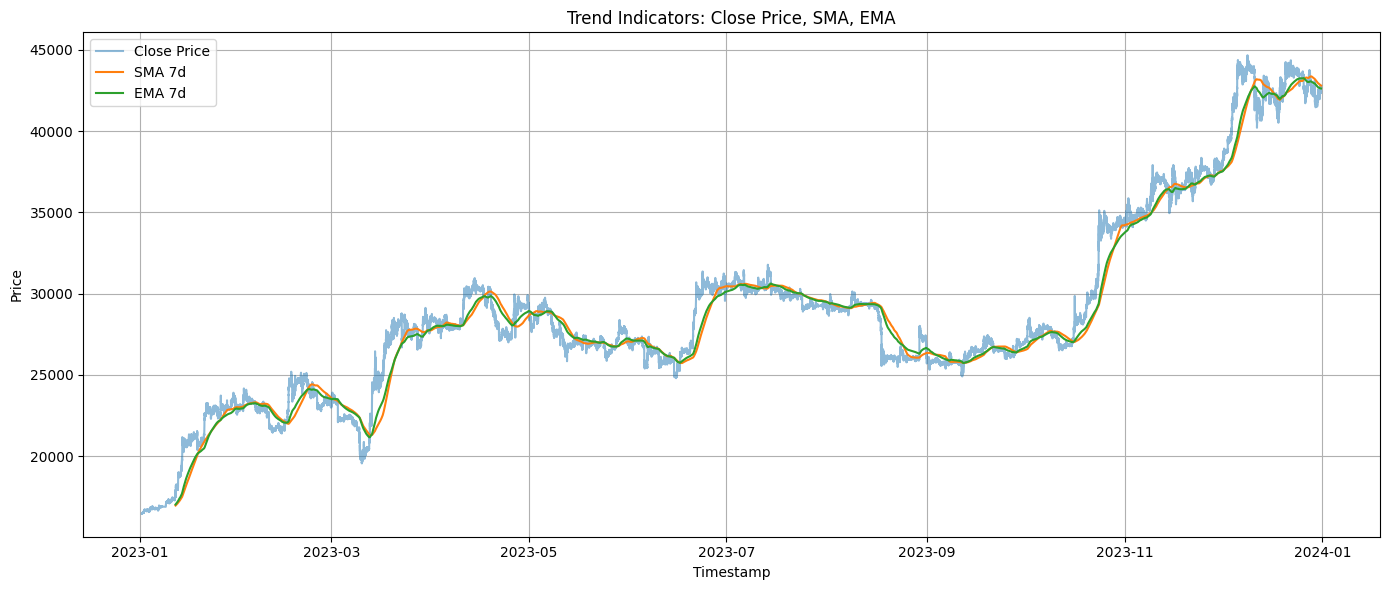

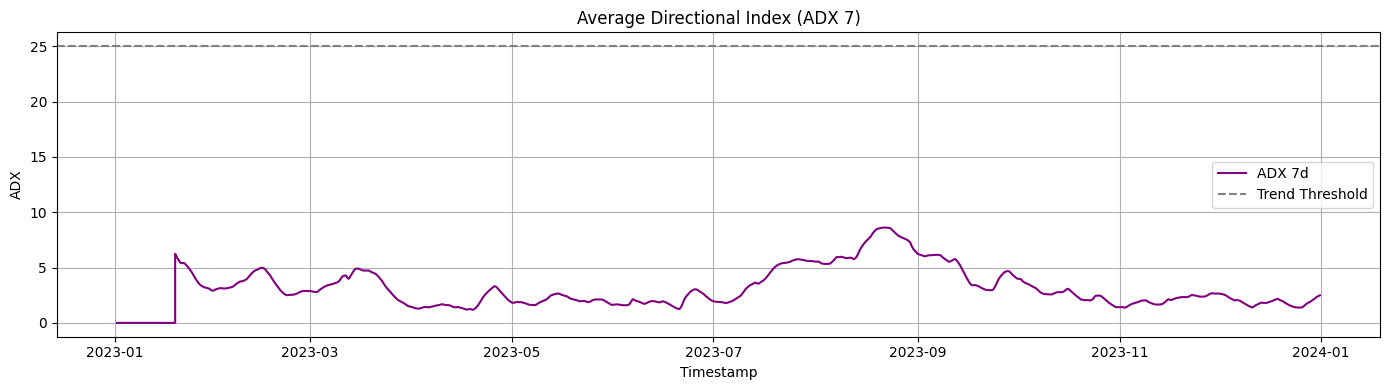

[INFO] Written trend indicators for BTC_Trend_Comparison_math to ArcticDB


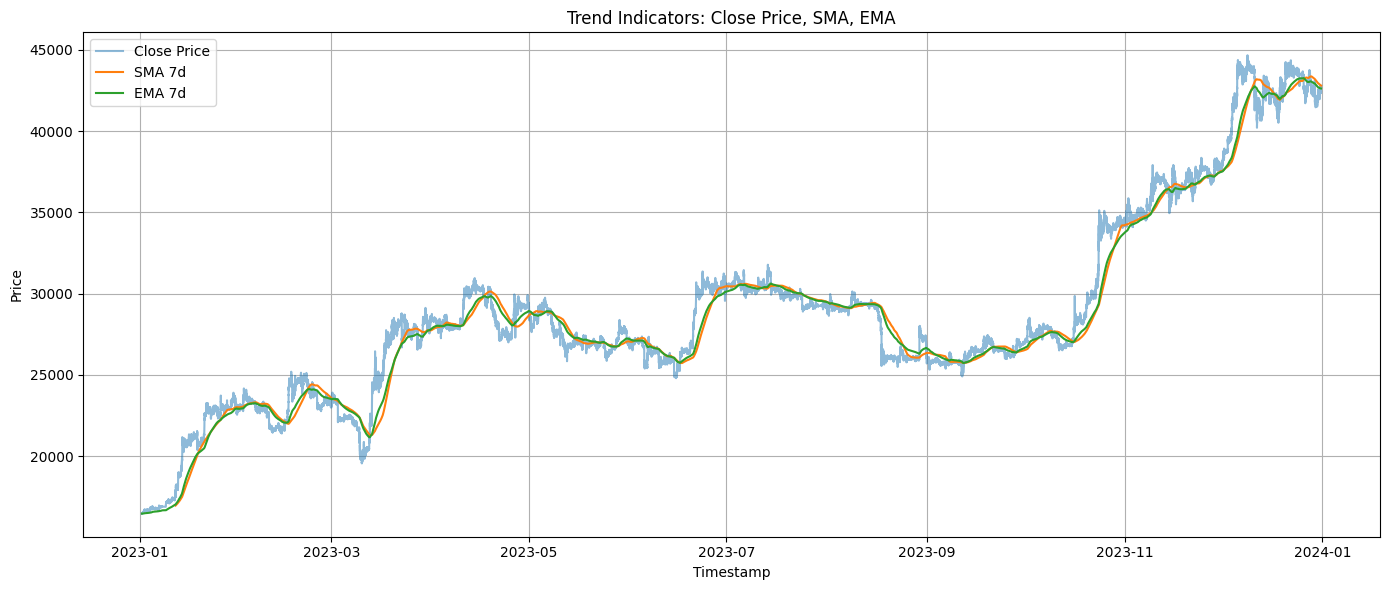

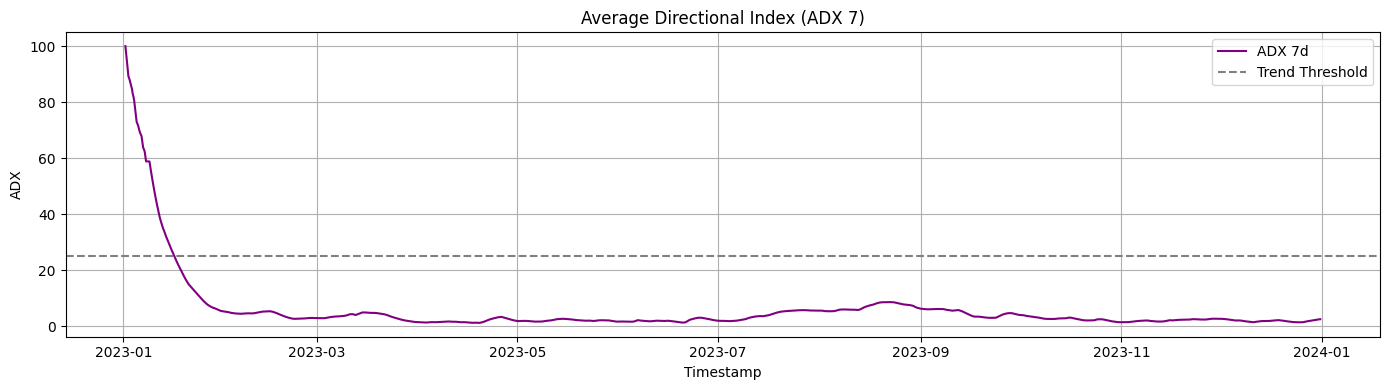

In [81]:
# Moving Average Indicator Comparison
df_test = pd.read_csv('/Users/zway/Desktop/BTC_Project/raw_datasets/BTCUSD_1m_2023.csv')
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])
df_test.set_index('Timestamp', inplace=True)

trend_ta = TrendIndicatorPipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
trend_math = TrendIndicatorPipeline_math(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")

df_ta = trend_ta.run(df_test, symbol='BTC_Trend_Comparison' + '_ta')
df_math = trend_math.run(df_test, symbol='BTC_Trend_Comparison' + '_math')

In [82]:
# Numerical error
def compare_trend_metric(df1, df2, column):
    df_combined = pd.DataFrame({
        'ta': df1[column],
        'math': df2[column]
    }).dropna()
    
    mae = (df_combined['ta'] - df_combined['math']).abs().mean()
    rmse = np.sqrt(((df_combined['ta'] - df_combined['math']) ** 2).mean())
    
    print(f'{column} – MAE: {mae:.4f}, RMSE: {rmse:.4f}')

In [83]:
compare_trend_metric(df_ta, df_math, 'sma_7d')
compare_trend_metric(df_ta, df_math, 'ema_7d')
compare_trend_metric(df_ta, df_math, 'adx_7d')

sma_7d – MAE: 0.0000, RMSE: 0.0000
ema_7d – MAE: 0.0000, RMSE: 0.0000
adx_7d – MAE: 2.1918, RMSE: 10.6501


In [84]:
def compare_trend_plot(df1, df2, column, label1='TA', label2='Math'):
    plt.figure(figsize=(14, 4))
    plt.plot(df1.index, df1[column], label=f'{label1} {column}', alpha=0.6)
    plt.plot(df2.index, df2[column], label=f'{label2} {column}', linestyle='--', alpha=0.6)
    plt.title(f'Comparison: {column} ({label1} vs {label2})')
    plt.legend(); plt.grid(); plt.tight_layout(); plt.show()

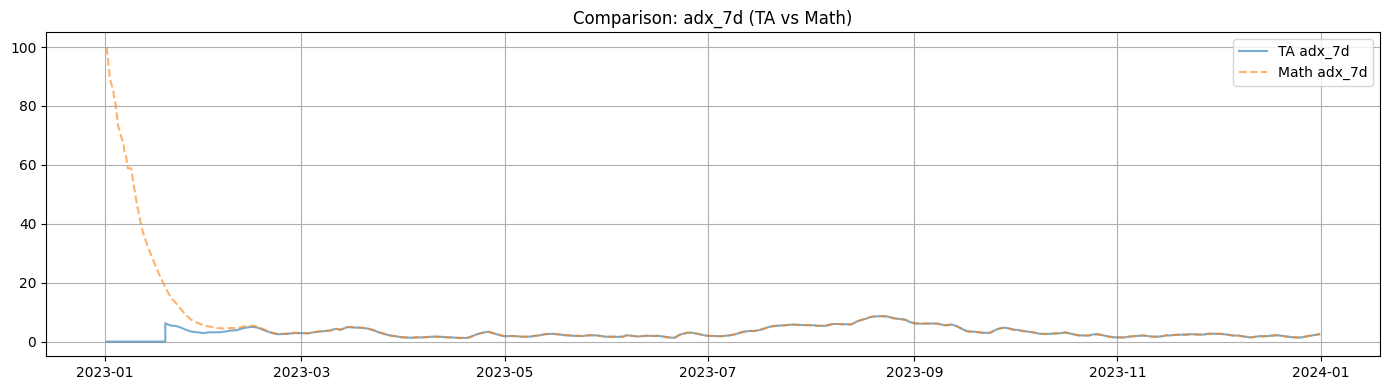

In [85]:
# Visualized difference
compare_trend_plot(df_ta, df_math, 'adx_7d')

20250622 21:35:37.321798 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]
20250622 21:35:37.323367 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]


[INFO] Written momentum indicators for BTC_MOM_TA to ArcticDB


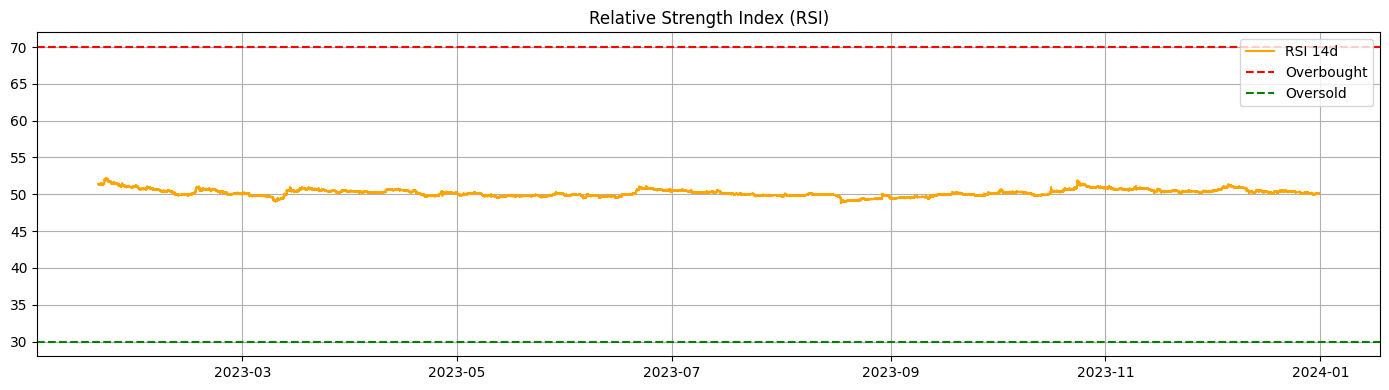

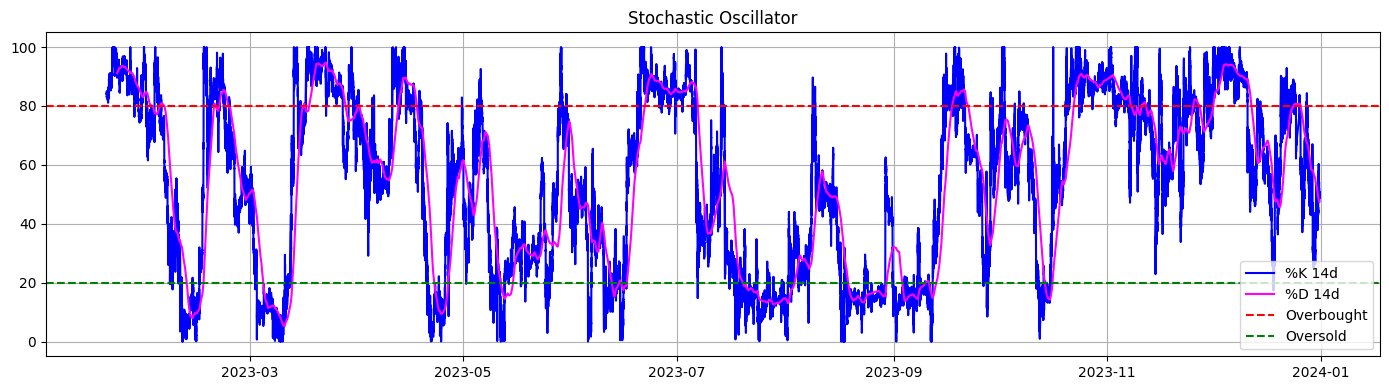

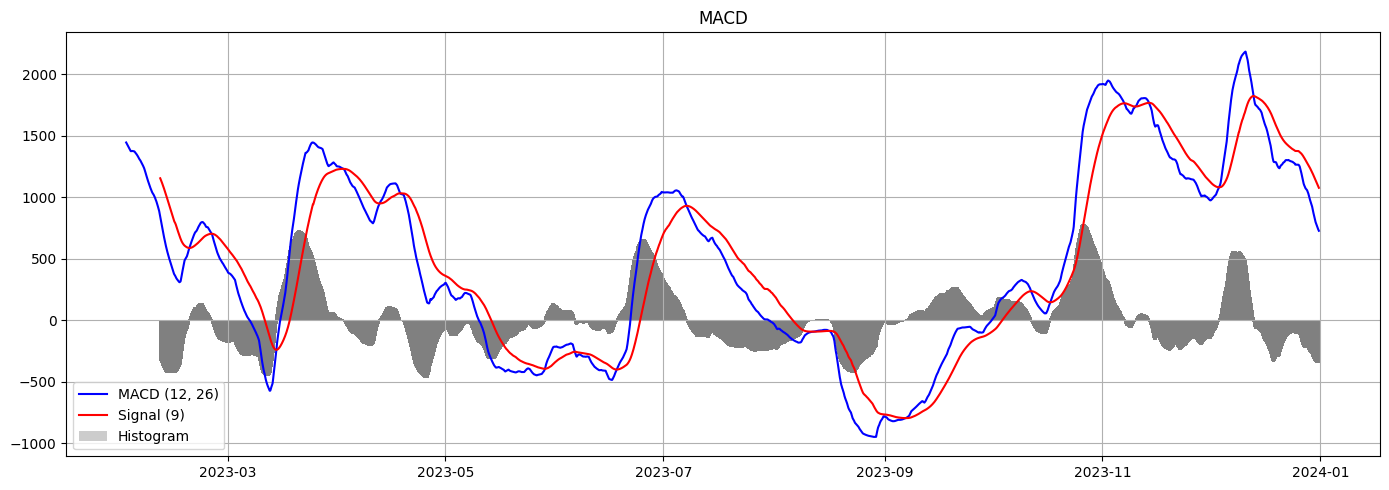

[INFO] Written momentum indicators for BTC_MOM_MATH to ArcticDB


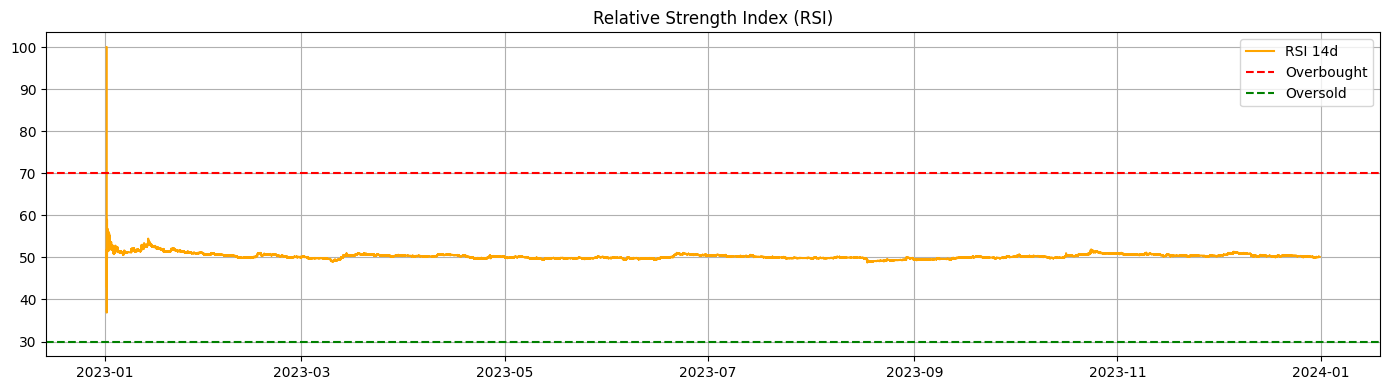

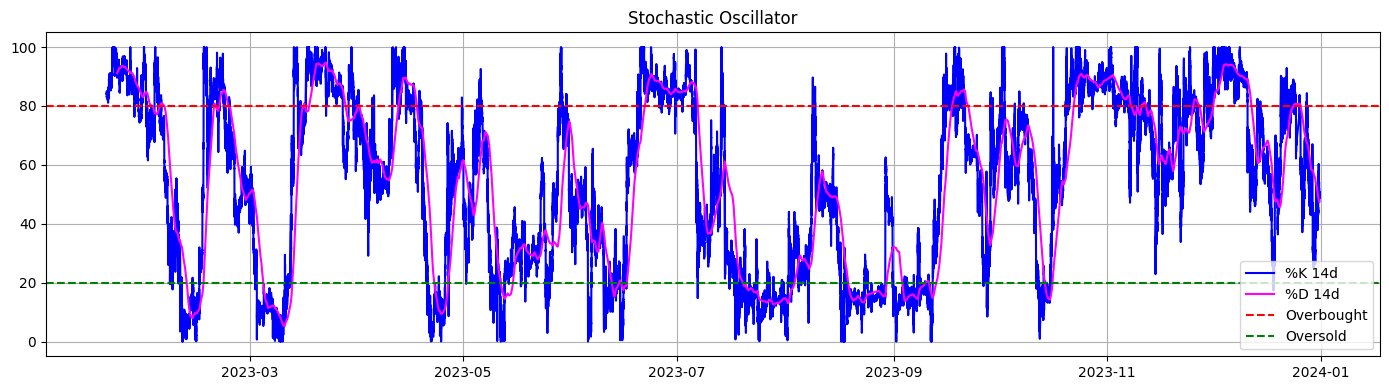

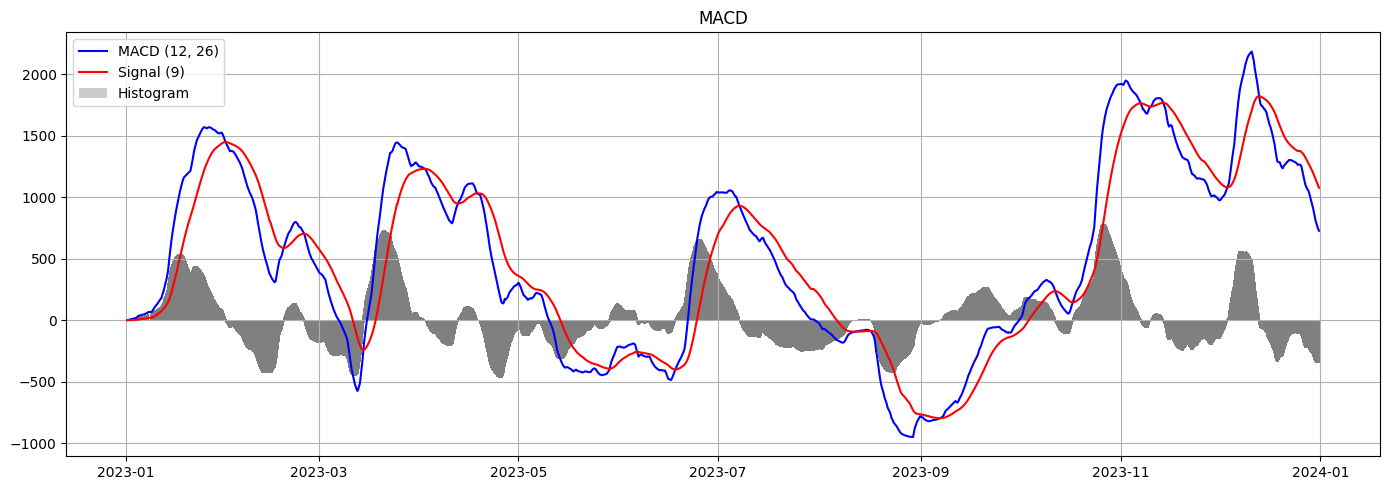

In [ ]:
# Momentum Indicator Comparison
momentum_ta = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
momentum_math = MomentumIndicatorPipeline_math(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")

df_ta = momentum_ta.run(df_test, symbol='BTC_MOM_TA')
df_math = momentum_math.run(df_test, symbol='BTC_MOM_MATH')

In [87]:
compare_trend_metric(df_ta, df_math, 'rsi_14d')
compare_trend_metric(df_ta, df_math, 'stoch_k_14d')
compare_trend_metric(df_ta, df_math, 'macd')

rsi_14d – MAE: 0.0000, RMSE: 0.0000
stoch_k_14d – MAE: 0.0000, RMSE: 0.0000
macd – MAE: 0.0000, RMSE: 0.0000


20250706 00:42:05.243661 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]
20250706 00:42:05.246246 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]


[INFO] Written volatility indicators for BTC_VOL_TA to ArcticDB


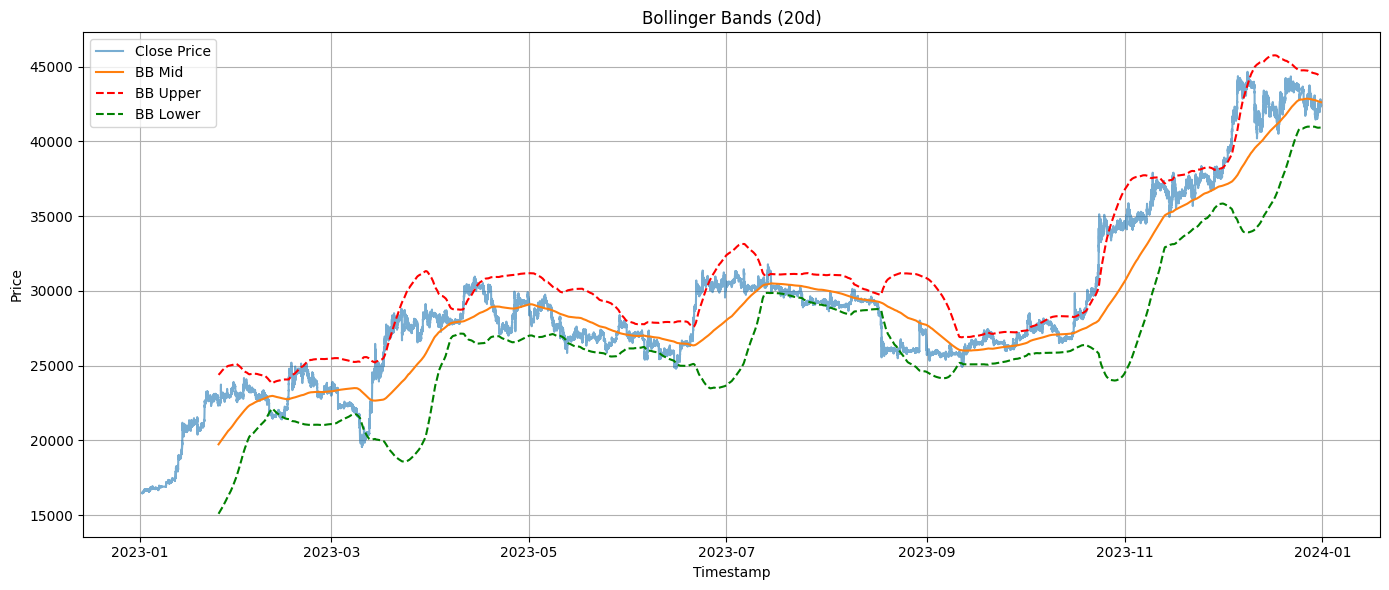

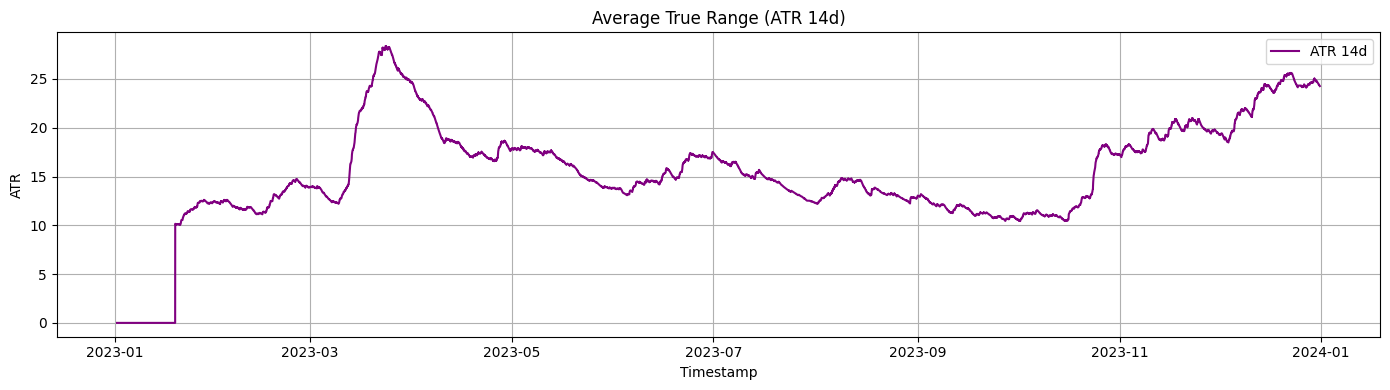

[INFO] Written volatility indicators (math) for BTC_VOL_MATH to ArcticDB


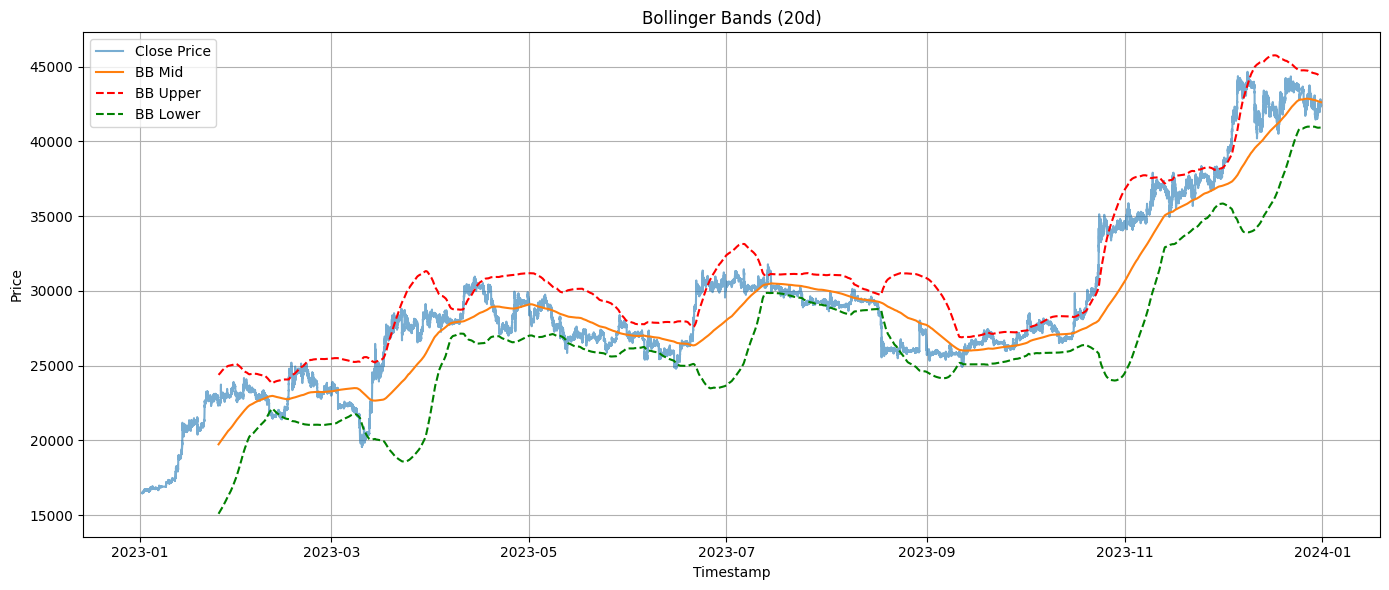

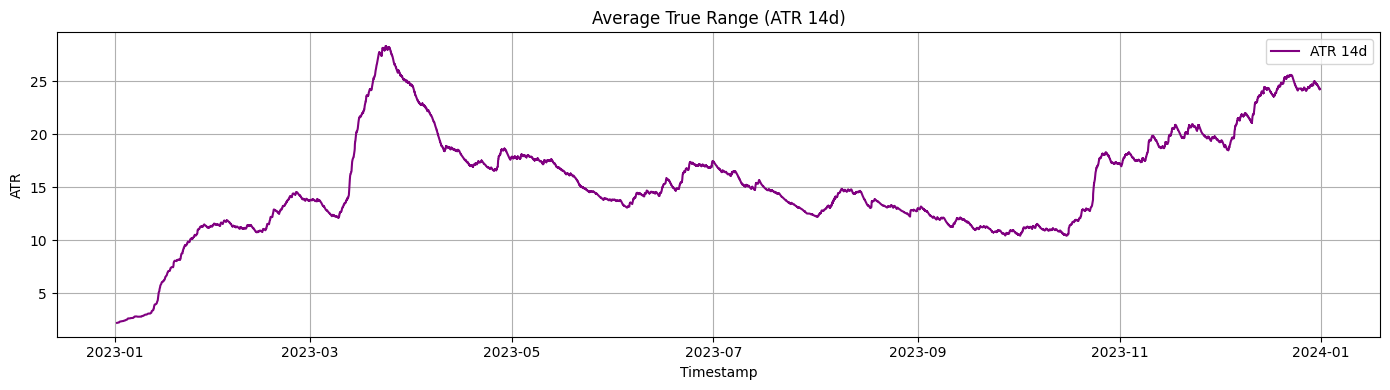

In [102]:
# Volatility Indicators Comparison
volatility_ta = VolatilityIndicatorPipeline(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")
volatility_math = VolatilityIndicatorPipeline_math(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")

df_ta = volatility_ta.run(df_test, symbol='BTC_VOL_TA')
df_math = volatility_math.run(df_test, symbol='BTC_VOL_MATH')

In [103]:
compare_trend_metric(df_ta, df_math, 'bb_mid_20d')
compare_trend_metric(df_ta, df_math, 'bb_upper_20d')
compare_trend_metric(df_ta, df_math, 'bb_lower_20d')
compare_trend_metric(df_ta, df_math, 'atr_14d')

bb_mid_20d – MAE: 0.0000, RMSE: 0.0000
bb_upper_20d – MAE: 0.0000, RMSE: 0.0000
bb_lower_20d – MAE: 0.0000, RMSE: 0.0000
atr_14d – MAE: 0.2657, RMSE: 1.0042


## Example Use

In [106]:
# Read dataset(s)
# Open ArcticDB libraries
ac = Arctic(f"lmdb://{DB_PATH}")
cleaned_lib = ac['cleaned_data']
engineered_lib = ac.get_library('engineered_data', create_if_missing=True)

trend_lib = ac['trend_indicators']
momentum_lib = ac['momentum_indicators']

20250720 00:36:24.106992 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]


20250720 00:36:30.102580 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]


[INFO] Written trend indicators for BTC_sample_1month to ArcticDB


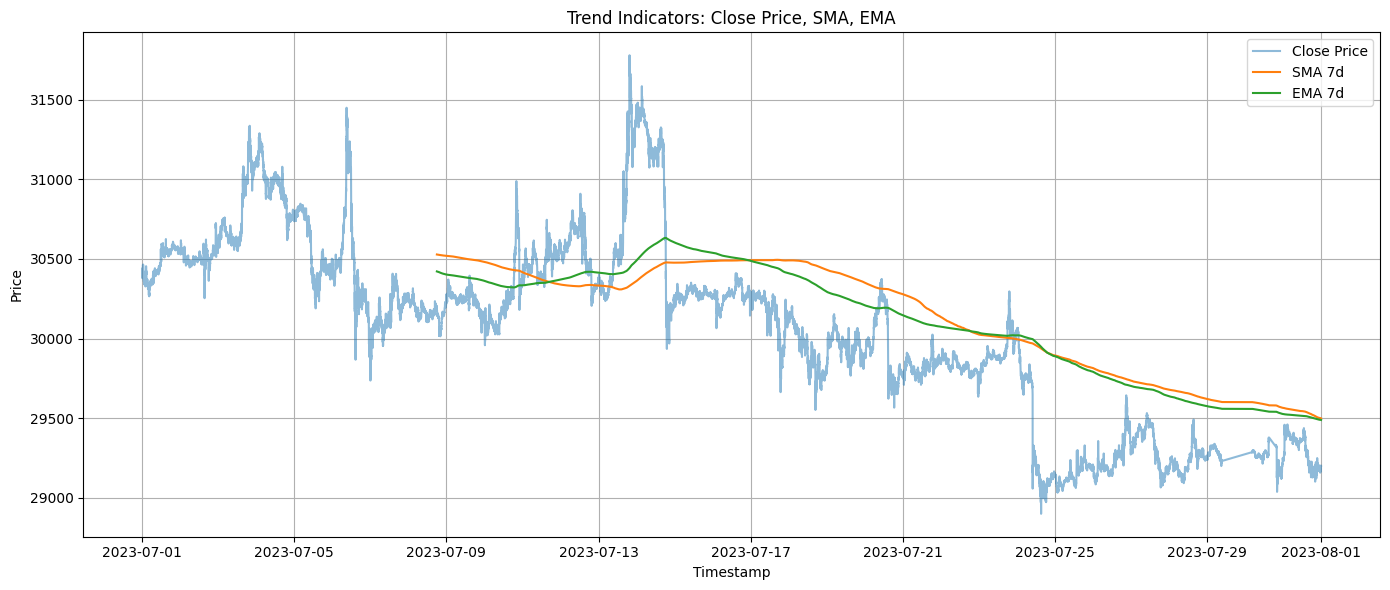

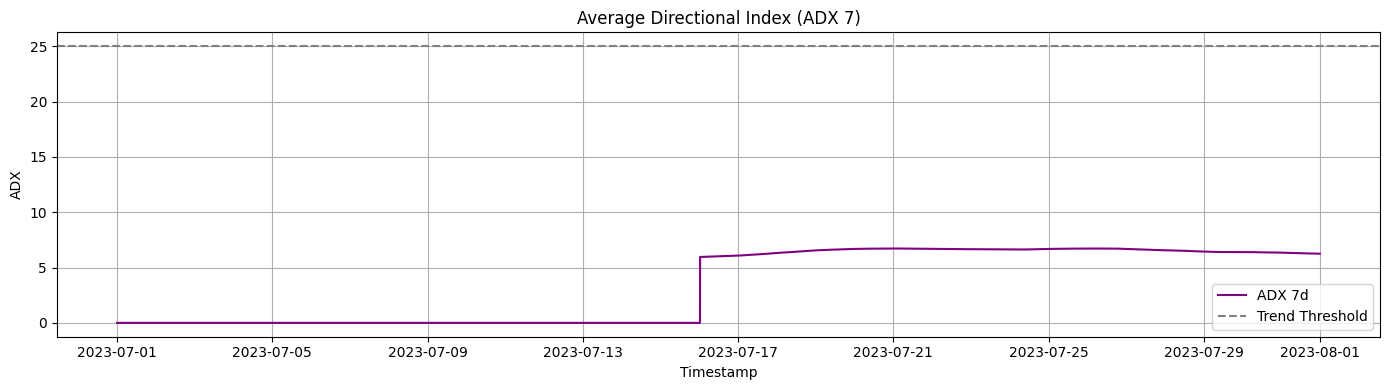

In [107]:
# sample run Moving Average
df = pd.read_csv('/Users/zway/Desktop/BTC_Project/raw_datasets/raw_sample_2023_07.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

pipeline = TrendIndicatorPipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
df_with_indicators = pipeline.run(df, symbol='BTC_sample_1month')

# sample run Momentum Indicator

# momentum_pipeline = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
# df_momentum = momentum_pipeline.run(df, symbol='BTC_sample_1month')


[INFO] Written rolling correlation indicators for BTC_SP500_corr to ArcticDB


20250720 01:17:31.678652 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]


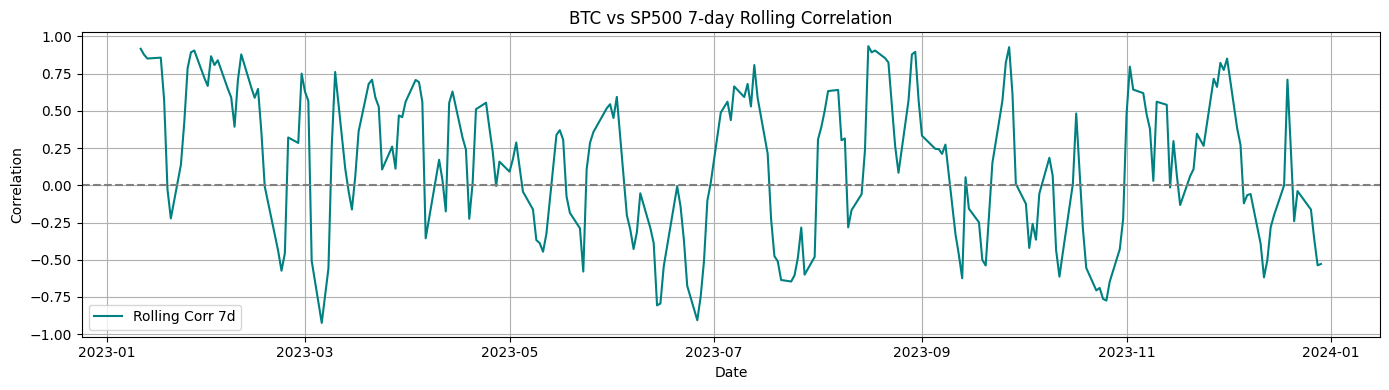

In [125]:
df_btc = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/BTC_daily_cleaned.csv', parse_dates=['datetime'], index_col='datetime')
df_sp = pd.read_csv('/Users/zway/Desktop/BTC_Project/Crypto_Research/data/SP500_daily_cleaned.csv', parse_dates=['Date'], index_col='Date')

corr_pipeline = CorrelationIndicatorPipeline(lib_name='correlation_indicators', store_path=f'lmdb://{DB_PATH}')
result_corr = corr_pipeline.run(
    df_btc, df_sp,
    symbol='BTC_SP500_corr',
    days_list=[7, 30],
    col1='BTC_Close',
    col2='SP500_Close'
)

In [112]:
print('BTC columns:', df_btc.columns.tolist())
print('SP500 columns:', df_sp.columns.tolist())

BTC columns: ['Unnamed: 0', 'Open', 'High', 'Low', 'BTC_Close', 'Volume']
SP500 columns: ['Unnamed: 0', 'Open', 'High', 'Low', 'SP500_Close']


20250720 00:37:04.432033 10512993 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[44538]


[INFO] Written fractal dimension indicators for BTC_FD to ArcticDB


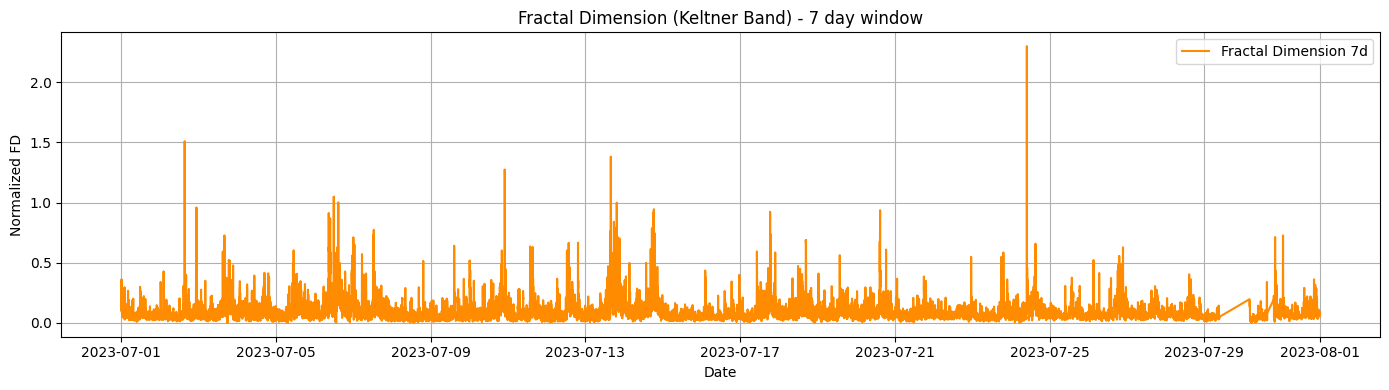

In [108]:
fd_pipeline = FractalDimensionPipeline(lib_name='fractal_indicators', store_path=f'lmdb://{DB_PATH}')
df_fd = fd_pipeline.run(df, symbol='BTC_FD', days_list=[7, 30])

In [90]:
df_trend = trend_lib.read('BTC_sample_1month').data

df_trend.head()

,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,Avg_price,sma_7d,ema_7d,adx_7d
Timestamp,,,,,,,,,,,
2023-07-01 00:00:00,1675787,1675787,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65,NaN,NaN,0.0
2023-07-01 00:01:00,1675788,1675788,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60,NaN,NaN,0.0
2023-07-01 00:02:00,1675789,1675789,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40,NaN,NaN,0.0
2023-07-01 00:03:00,1675790,1675790,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45,NaN,NaN,0.0
2023-07-01 00:04:00,1675791,1675791,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30,NaN,NaN,0.0


In [91]:
df_momentum = momentum_lib.read('BTC_sample_1month').data

df_momentum.head()

,Unnamed: 0.1,Unnamed: 0,Open,High,Low,Close,Volume,Avg_price,rsi_14d,stoch_k_14d,stoch_d_14d,macd,macd_signal,macd_diff
Timestamp,,,,,,,,,,,,,,
2023-07-01 00:00:00,1675787,1675787,30407.1,30418.2,30407.1,30416.9,0.000027,30412.65,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000
2023-07-01 00:01:00,1675788,1675788,30416.9,30416.9,30392.3,30393.2,0.000016,30404.60,0.000000,NaN,NaN,-0.001477,-2.278999e-07,-0.001477
2023-07-01 00:02:00,1675789,1675789,30393.5,30417.3,30393.5,30402.2,0.000074,30405.40,27.523925,NaN,NaN,-0.002393,-5.970816e-07,-0.002392
2023-07-01 00:03:00,1675790,1675790,30404.1,30420.8,30404.1,30413.4,0.000056,30412.45,46.015583,NaN,NaN,-0.002610,-9.998000e-07,-0.002609
2023-07-01 00:04:00,1675791,1675791,30413.6,30427.2,30413.4,30422.8,0.000039,30420.30,55.537176,NaN,NaN,-0.002242,-1.345654e-06,-0.002241
